In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

### Spergel scarlet fitting errors

In [525]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:5000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:5000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
print('Incomplete files:', np.sum(bad_flag))
print('Failed modelings:', np.isnan(meas_cat['rhalf_circularized']).sum())
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
print('Surface brightness cut:', np.sum(~(params_cat['SB_eff_g'] > 28)))
bad_flag |= (params_cat['SB_eff_g'] > 28)
print('Spergel size cut:', np.sum(~(meas_cat['rhalf_spergel'] * 0.168 < 1)))
bad_flag |= (meas_cat['rhalf_spergel'] * 0.168 < 1)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]

print('Number of survived objs afterall:', len(obj_cat))

meas_cat['rhalf_spergel'] = 0.168 * meas_cat['rhalf_spergel']
meas_cat['rhalf_circularized'] = 0.168 * meas_cat['rhalf_circularized']
meas_cat['sersic_rhalf'] = 0.168 * meas_cat['sersic_rhalf']


Total number of objects: 5000
Incomplete files: 81
Failed modelings: 54
Surface brightness cut: 4438
Spergel size cut: 4954
Number of survived objs afterall: 4361


In [526]:
re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

ell_truth = params_cat['ellip'].data
ell_meas = meas_cat['ell_sym'].data

gi_truth = params_cat['g-i'].data
gi_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]).data

g_meas = meas_cat['mag'][:, 0].data
g_truth = params_cat['mag_g'].data

spergel_nu = meas_cat['spergel_nu'].data

-0.5871373553598329 1.245634452037271


### Three methods
1. Train a nueral net to predict truth for each mock galaxy.
    For this method, bias correction works very well, but it will be hard to derive std using this method. Std requires binning anyway. 
    
2. Bin the parameter space, calculate `delta = (meas - truth)`, then fit a polynomial for delta as a function of parameters.
    This would work fine?
    
3. same as 2, but replace the polynomial with a neural net.  

### Method 1

In [7]:
def predict_bias_NN(y, X, degree=2, hidden_layer_sizes=(64, 64, 64), random_state=42):
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.neural_network import MLPRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    if random_state is None:
        random_state = 1
    # Polynomial features
    pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler())
    X_poly = pipeline.fit_transform(X)
    
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, 
                                                                  test_size=0.3, 
                                                                  random_state=random_state)
    
    # NN regressor
    regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                        random_state=random_state, 
                        max_iter=500
                       ).fit(X_train_poly, y_train)
    print('Score:', regr.score(X_test_poly, y_test))
    pipeline2 = make_pipeline(pipeline, regr)
    return pipeline2

In [9]:
X = np.vstack([re_meas, SB_meas, spergel_nu]).T #, gi_meas, spergel_nu # spergel_nu
y = re_truth
ppl = predict_bias_NN(y, X)
re_truth_pred = ppl.predict(X)
np.mean(re_truth_pred - y)

Score: 0.9030598115625299


0.1488744092239485

(2.0, 15.0)

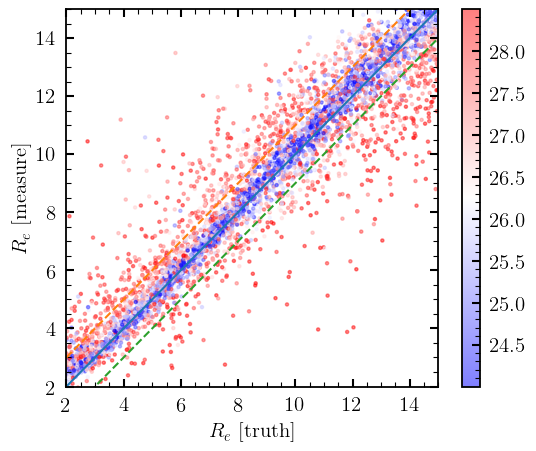

In [10]:
plt.scatter(re_truth, re_truth_pred, 
            c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [13]:
X = np.vstack([g_meas, re_meas, SB_meas,]).T# , gi_meas, spergel_nu # spergel_nu
y = g_truth
ppl = predict_bias_NN(y, X)
g_truth_pred = ppl.predict(X)
np.mean(g_truth_pred - y)

Score: 0.973504512456604


-0.0307690953437035

Text(0, 0.5, '$g$ [measure]')

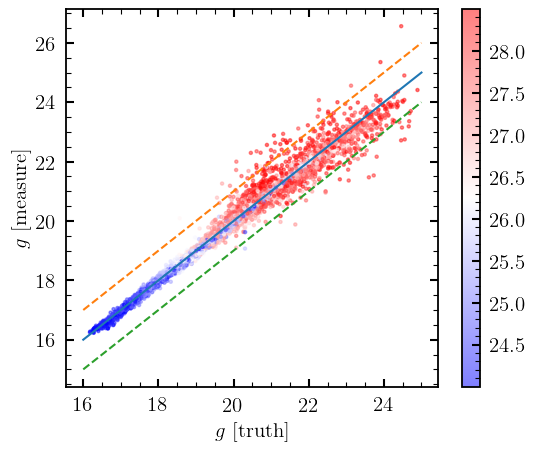

In [15]:
plt.scatter(g_truth, g_truth_pred, 
            c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(16, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

# plt.xticks(ticks=np.arange(2, 15, 2))
# plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$g$ [truth]')
plt.ylabel(r'$g$ [measure]')
# plt.xlim(2, 15)
# plt.ylim(2, 15)

In [16]:
X = np.vstack([re_meas, SB_meas]).T # , gi_meas, spergel_nu # spergel_nu
y = SB_truth
ppl = predict_bias_NN(y, X)
SB_truth_pred = ppl.predict(X)
np.mean(SB_truth_pred - y)

Score: 0.9846972747019646


0.03627178447148351

Text(0, 0.5, '$R_e$ [measure]')

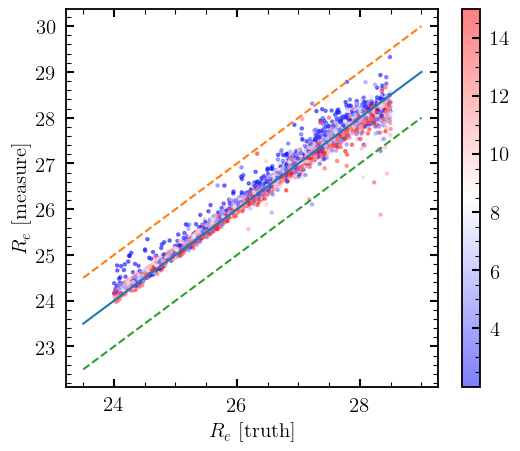

In [17]:
plt.scatter(SB_truth, SB_truth_pred, 
            c=re_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(23.5, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

# plt.xticks(ticks=np.arange(2, 15, 2))
# plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')

### Method 3

In [558]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
from sample_cuts import bin_data, quant_error, get_edge_cens, bin_data_moving_window
from scipy.stats import binned_statistic_dd

from sample_cuts import quant_measurement

Score: 0.9452232465421989


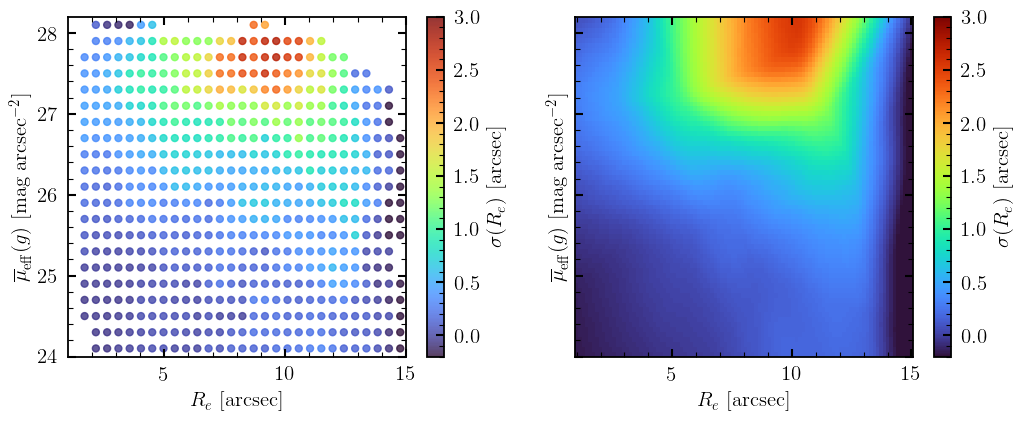

In [581]:
re_bias = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    re_truth - re_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=3
)

Score: 0.78049527021956


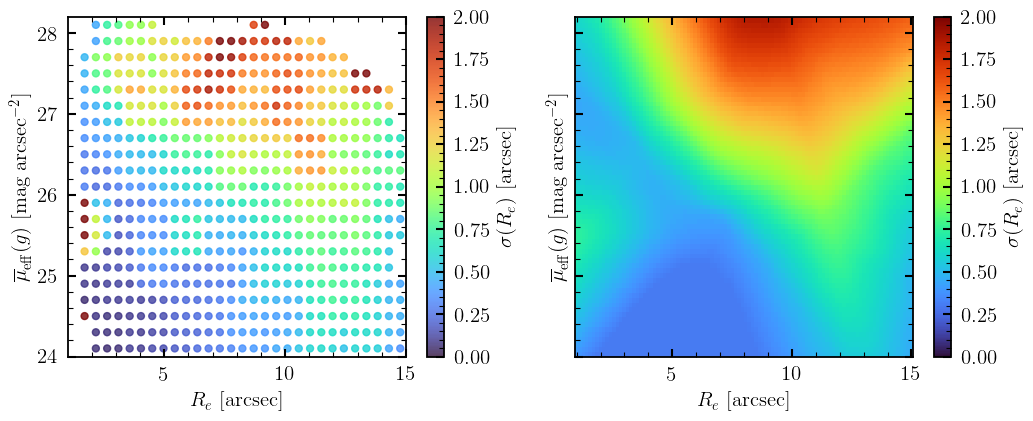

In [582]:
re_std = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    re_truth - re_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=0.3,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=2, cbar_label=r'$\sigma(R_e)$ [arcsec]',
)

(2.0, 15.0)

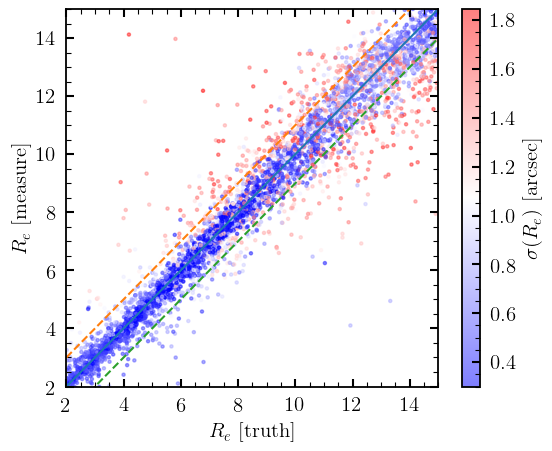

In [583]:
re_meas_corr = re_meas + re_bias.predict(np.vstack([re_meas, SB_meas]).T)
re_meas_std = re_std.predict(np.vstack([re_meas, SB_meas]).T)
re_meas_std[re_meas_std < 0.3] = 0.3

plt.scatter(re_truth, re_meas_corr, 
            c=re_meas_std, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(label=r'$\sigma(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [corrected]')
plt.xlim(2, 15)
plt.ylim(2, 15)

Score: 0.8463598385756768


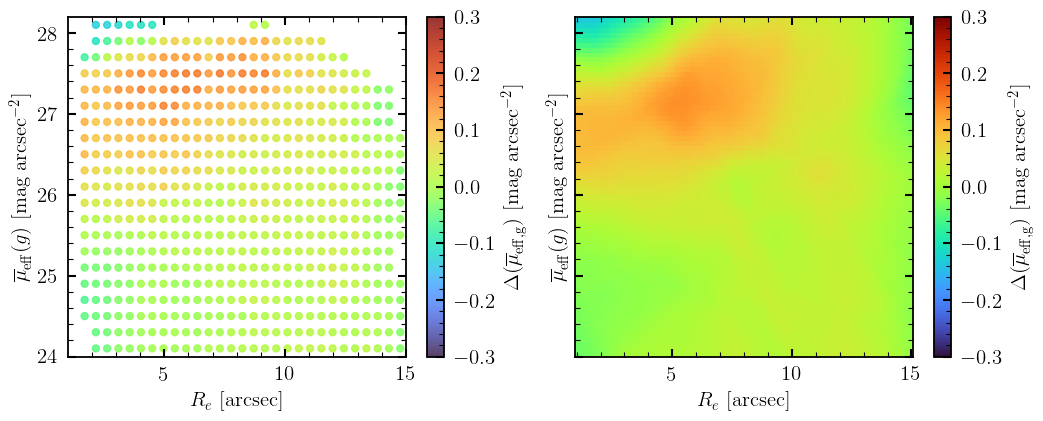

In [584]:
SB_bias = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    SB_truth - SB_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=-0.3, vmax=0.3, cbar_label=r'$\Delta(\overline{\mu}_{\rm eff, g})$ [mag arcsec$^{-2}$]',
)

Score: 0.5969411853694826


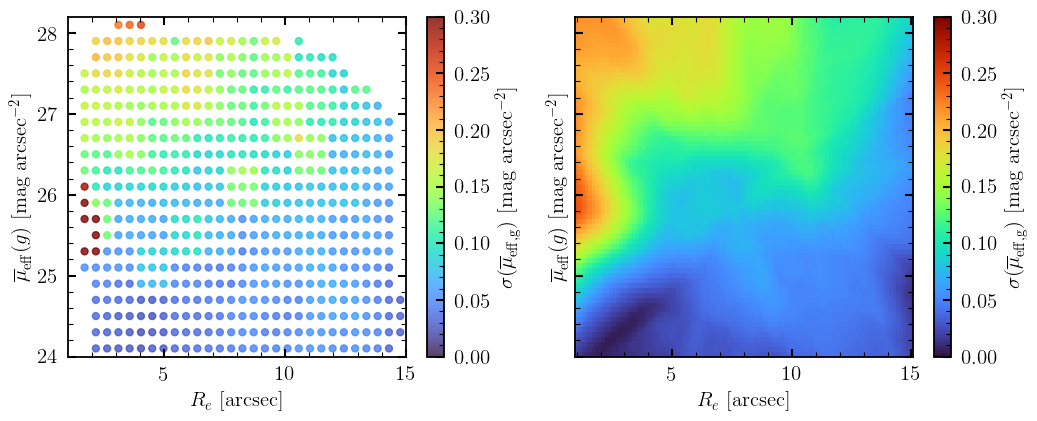

In [585]:
SB_std = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    SB_truth - SB_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=25,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.3, cbar_label=r'$\sigma(\overline{\mu}_{\rm eff, g})$ [mag arcsec$^{-2}$]',
)

(23.0, 29.0)

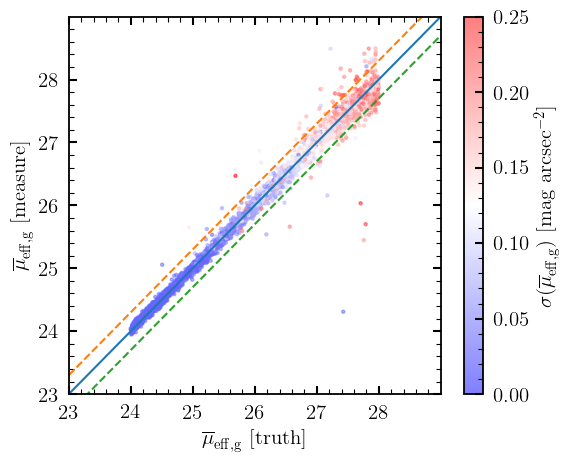

In [602]:
SB_meas_corr = SB_meas + SB_bias.predict(np.vstack([re_meas, SB_meas]).T)
SB_meas_std = SB_std.predict(np.vstack([re_meas, SB_meas]).T)
SB_meas_std[SB_meas_std < 0.05] = 0.05

plt.scatter(SB_truth, SB_meas_corr, 
            c=SB_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.25,
            s=5, alpha=0.5)
x = np.linspace(23, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.xticks(ticks=np.arange(23, 29, 1))
plt.yticks(ticks=np.arange(23, 29, 1))
plt.colorbar(label=r'$\sigma(\overline{\mu}_{\rm eff, g})$ [mag arcsec$^{-2}$]')
plt.xlabel(r'$\overline{\mu}_{\rm eff, g}$ [truth]')
plt.ylabel(r'$\overline{\mu}_{\rm eff, g}$ [corrected]')
plt.xlim(23, 29)
plt.ylim(23, 29)

Score: 0.8518026403537607


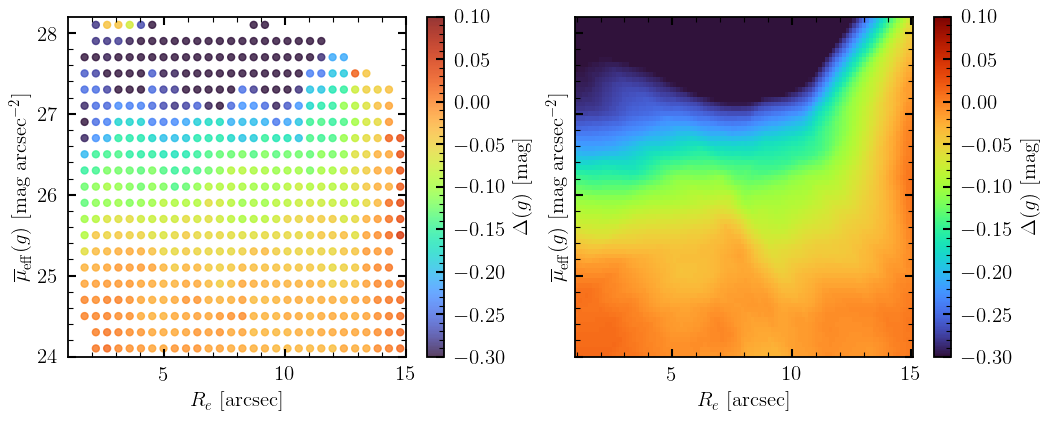

In [604]:
mag_bias = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    g_truth - g_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=-0.3, vmax=0.1, cbar_label=r'$\Delta(g)$ [mag]',
)

Score: 0.8684726903887389


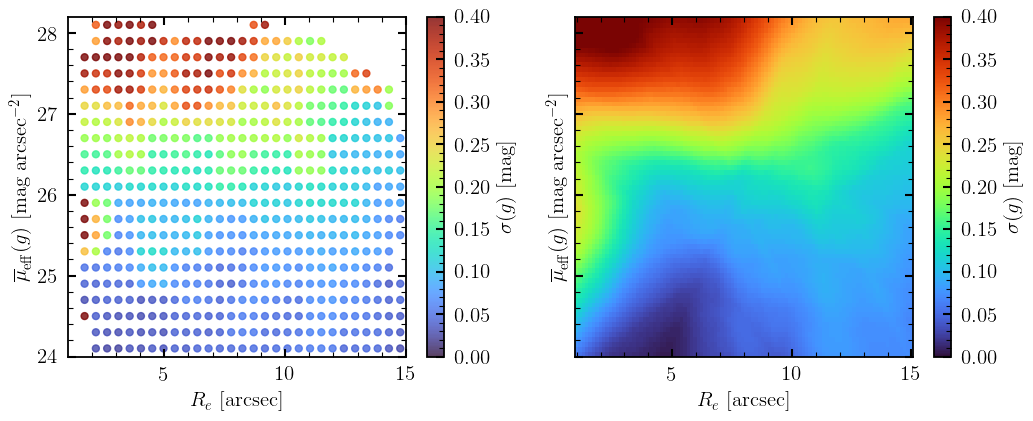

In [607]:
mag_std = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    g_truth - g_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g)$ [mag]',
)

(16.0, 25.0)

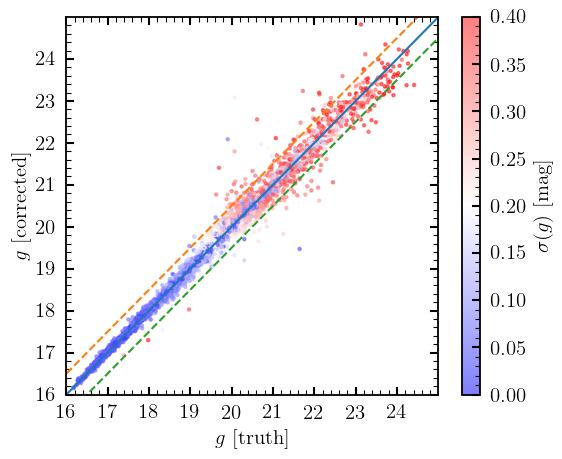

In [619]:
g_meas_corr = g_meas + mag_bias.predict(np.vstack([re_meas, SB_meas]).T)
g_meas_std = mag_std.predict(np.vstack([re_meas, SB_meas]).T)
g_meas_std[g_meas_std < 0.05] = 0.05

plt.scatter(g_truth, g_meas_corr, 
            c=g_meas_std, 
            cmap='bwr',
            vmin=0.,
            vmax=0.4,
            s=5, alpha=0.5)
x = np.linspace(16, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.5, '--')
plt.plot(x, x - 0.5, '--')

plt.xticks(ticks=np.arange(16, 25, 1))
plt.yticks(ticks=np.arange(16, 25, 1))
plt.colorbar(label=r'$\sigma(g)$ [mag]')
plt.xlabel(r'$g$ [truth]')
plt.ylabel(r'$g$ [corrected]')
plt.xlim(16, 25)
plt.ylim(16, 25)

Score: 0.3080665072415715


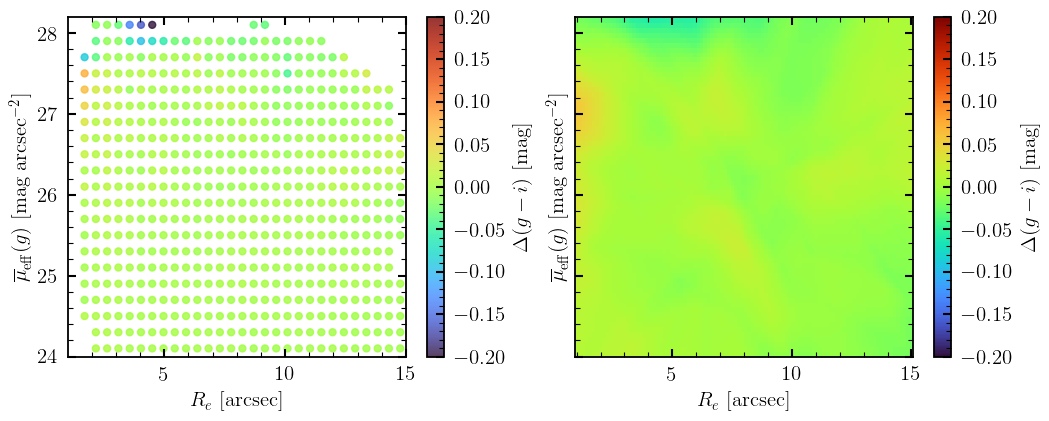

In [625]:
gi_bias = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    gi_truth - gi_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='median',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=-0.2, vmax=0.2, cbar_label=r'$\Delta(g-i)$ [mag]',
)

Score: 0.8611509121049421


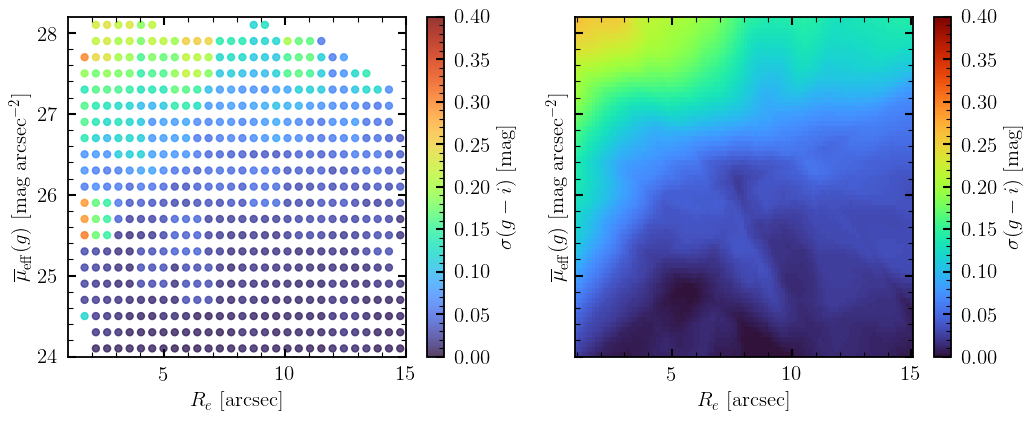

In [626]:
go_std = quant_measurement(
    np.vstack([re_meas, SB_meas]).T,
    gi_truth - gi_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 29]],
    statistic='std',
    min_value=None,
    min_num=15,
    degree=2,
    ylim=[24, 28.2], vmin=0, vmax=0.4, cbar_label=r'$\sigma(g-i)$ [mag]',
)

In [464]:
xs, y = bin_data_moving_window(
    np.vstack([re_meas, SB_meas]).T,
    re_truth - re_meas,
    n_slide=[5, 5],
    n_bins=[12, 12],
    _range=[[1, 15], [23, 30]],
    statistic='median',
    min_err=0.,
    min_num=15,)

ppl_bias = predict_bias_NN(y, xs, degree=2, hidden_layer_sizes=(128, 64, 64))

x1_test, x2_test = np.meshgrid(np.linspace(2, 15, 100),
                               np.linspace(24, 28.5, 100))
C = ppl_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
# C[C <= 0] = 0.0

Score: 0.9623888235053323


Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

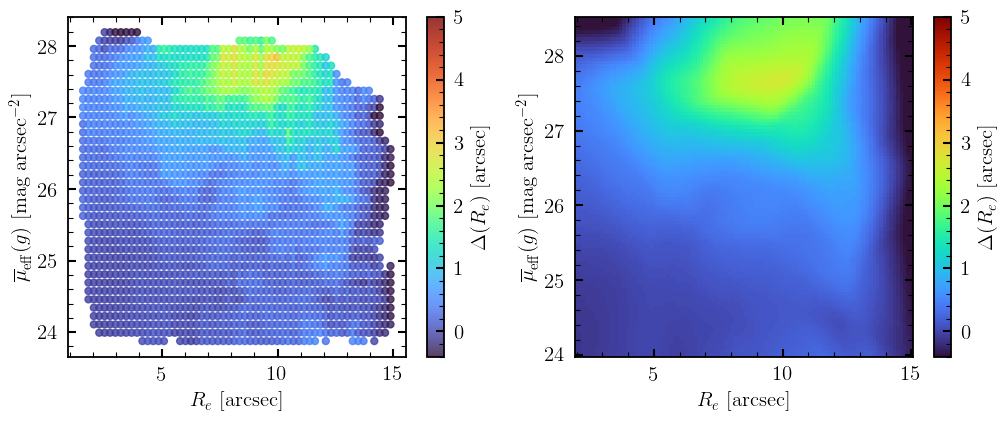

In [465]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.5))
plt.sca(ax1)
plt.scatter(xs[:, 0], xs[:, 1], c=y, vmin=-0.4, vmax=5, s=25, alpha=0.8)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.sca(ax2)
plt.pcolormesh(x1_test, x2_test, C.reshape(*x1_test.shape), vmin=-0.4, vmax=5, alpha=1)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

In [466]:
## test results

In [467]:
np.std(re_truth - re_meas - ppl_bias.predict(np.vstack([re_meas, SB_meas]).T))

1.0734735625911935

(2.0, 15.0)

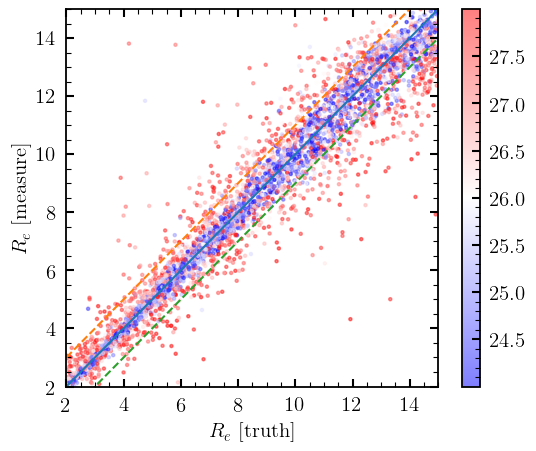

In [468]:
plt.scatter(re_truth, re_meas + ppl_bias.predict(np.vstack([re_meas, SB_meas]).T), 
            c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [469]:
xs, y = bin_data_moving_window(
    np.vstack([re_meas, SB_meas]).T,
    re_truth - re_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 30]],
    statistic='std',
    min_err=0.3,
    min_num=15,)

ppl_std = predict_bias_NN(y, xs, degree=2, hidden_layer_sizes=(64, 64, 64))

x1_test, x2_test = np.meshgrid(np.linspace(2, 15, 100),
                               np.linspace(24, 28.5, 100))
C = ppl_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C[C <= 0] = 0.3

Score: 0.7649383971110748


Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

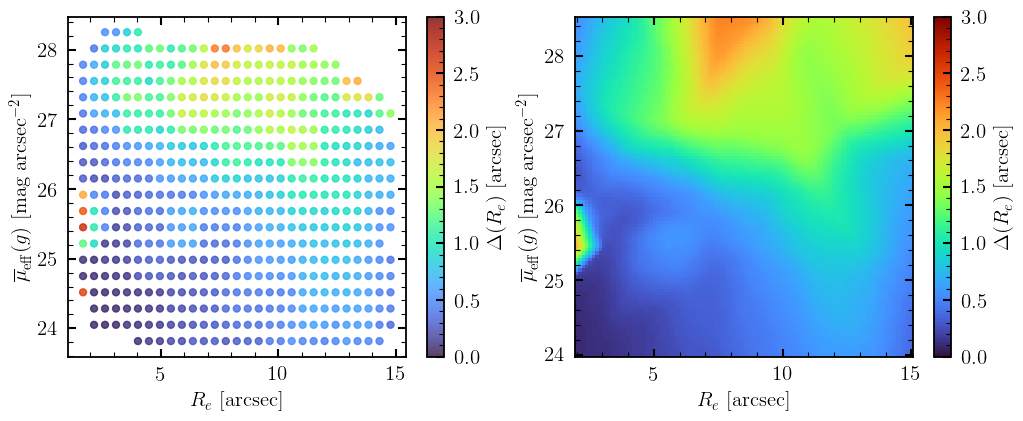

In [470]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.5))
plt.sca(ax1)
plt.scatter(xs[:, 0], xs[:, 1], c=y, vmin=0, vmax=3, s=25, alpha=0.8)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.sca(ax2)
plt.pcolormesh(x1_test, x2_test, C.reshape(*x1_test.shape), vmin=0, vmax=3, alpha=1)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

In [471]:
re_meas_corr = re_meas + ppl_bias.predict(np.vstack([re_meas, SB_meas]).T)
re_meas_std = ppl_std.predict(np.vstack([re_meas, SB_meas]).T)
re_meas_std[re_meas_std < 0.3] = 0.3

(-5.0, 5.0)

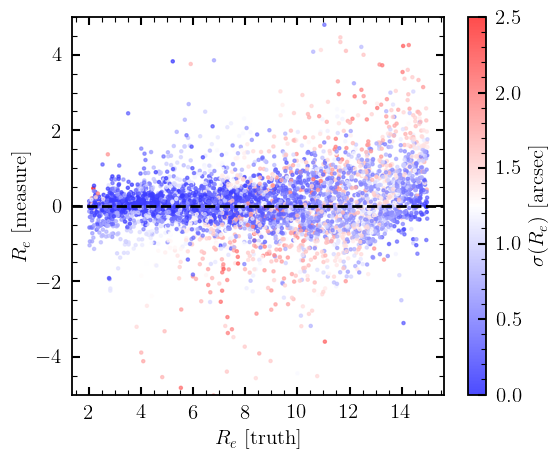

In [472]:
plt.scatter(re_truth, re_truth - re_meas_corr, 
            c=re_meas_std, 
            cmap='bwr',
            vmin=0, vmax=2.5,
            s=5, alpha=0.7)

plt.xticks(ticks=np.arange(2, 15, 2))

plt.axhline(0, ls='--', lw=2, color='k')
plt.colorbar(label=r'$\sigma(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.ylim(-5, 5)

(2.0, 15.0)

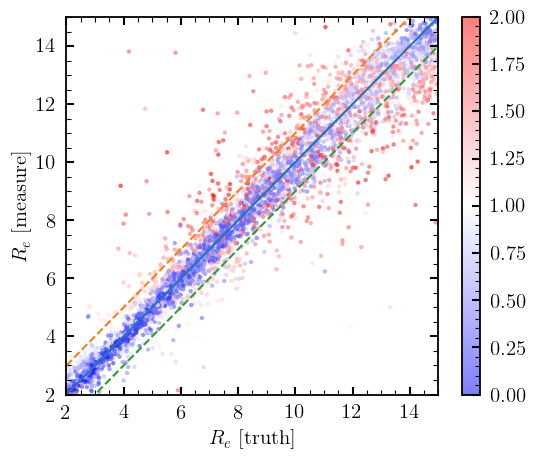

In [473]:
plt.scatter(re_truth, re_meas + ppl_bias.predict(np.vstack([re_meas, SB_meas]).T), 
            c=ppl_std.predict(np.vstack([re_meas, SB_meas]).T), 
            cmap='bwr',
            vmin=0, vmax=2,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

### SB

In [474]:
xs, y = bin_data_moving_window(
    np.vstack([re_meas, SB_meas]).T,
    SB_truth - SB_meas,
    n_slide=[5, 5],
    n_bins=[12, 12],
    _range=[[1, 15], [23, 30]],
    statistic='median',
    min_err=0.,
    min_num=15,)

ppl_bias = predict_bias_NN(y, xs, degree=2, hidden_layer_sizes=(128, 64, 64))

x1_test, x2_test = np.meshgrid(np.linspace(2, 15, 100),
                               np.linspace(24, 28.5, 100))
C = ppl_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
# C[C <= 0] = 0.0

Score: 0.880371730621854


Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

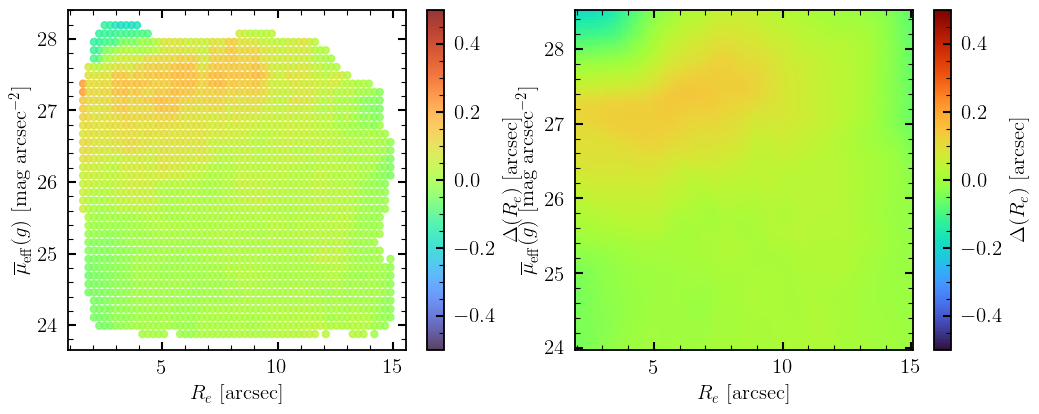

In [475]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.5))
plt.sca(ax1)
plt.scatter(xs[:, 0], xs[:, 1], c=y, vmin=-0.5, vmax=0.5, s=25, alpha=0.8)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.sca(ax2)
plt.pcolormesh(x1_test, x2_test, C.reshape(*x1_test.shape), vmin=-0.5, vmax=0.5, alpha=1)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

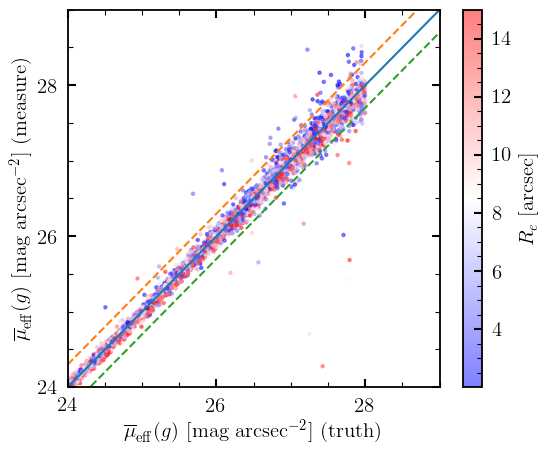

In [476]:
plt.scatter(SB_truth, SB_meas + ppl_bias.predict(np.vstack([re_meas, SB_meas]).T), 
            c=re_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.colorbar(label='$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlim(24, 29)
plt.ylim(24, 29)
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

In [488]:
xs, y = bin_data_moving_window(
    np.vstack([re_meas, SB_meas]).T,
    SB_truth - SB_meas,
    n_slide=[3, 3],
    n_bins=[10, 10],
    _range=[[1, 15], [23, 30]],
    statistic='std',
    min_err=0.1,
    min_num=20,)

ppl_std = predict_bias_NN(y, xs, degree=2, hidden_layer_sizes=(64, 64, 64))

x1_test, x2_test = np.meshgrid(np.linspace(2, 15, 100),
                               np.linspace(24, 28.5, 100))
C = ppl_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
# C[C <= 0] = 0.3

Score: 0.6436206885909812


Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

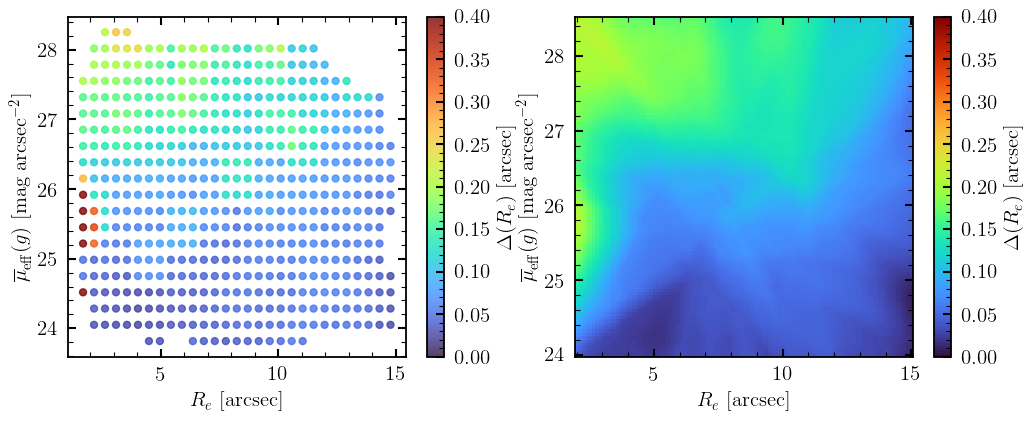

In [489]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.5))
plt.sca(ax1)
plt.scatter(xs[:, 0], xs[:, 1], c=y, vmin=0, vmax=0.4, s=25, alpha=0.8)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.sca(ax2)
plt.pcolormesh(x1_test, x2_test, C.reshape(*x1_test.shape), vmin=0, vmax=0.4, alpha=1)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')
plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

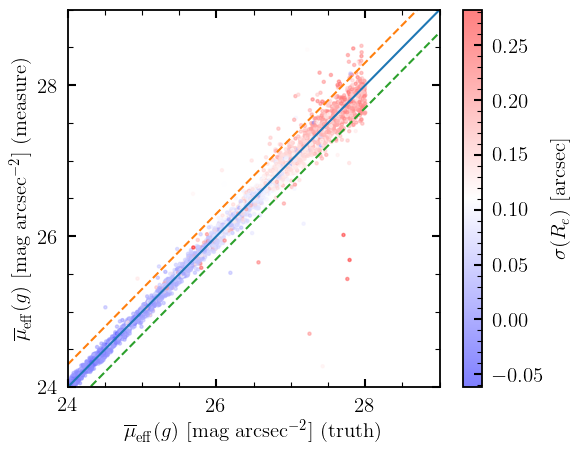

In [491]:
plt.scatter(SB_truth, SB_meas + ppl_bias.predict(np.vstack([re_meas, SB_meas]).T), 
            c=ppl_std.predict(np.vstack([re_meas, SB_meas]).T), 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')

plt.colorbar(label='$\sigma(R_e)$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlim(24, 29)
plt.ylim(24, 29)
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

---

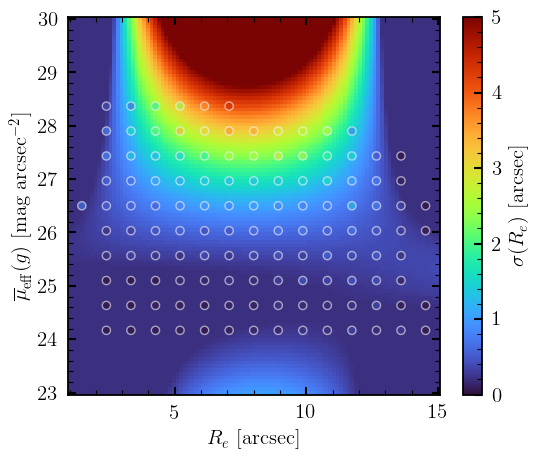

In [382]:
p_bias = quant_error(np.vstack([re_meas, SB_meas]).T, re_truth - re_meas, 
            statistic='mean',
            min_err=0.2, min_num=10,
            vmin=0, vmax=5, degree=[2, 2], method='chebyshev')

In [383]:
np.median(re_meas + p_bias(re_meas, SB_meas) - re_truth)

0.06619145622906597

(2.0, 15.0)

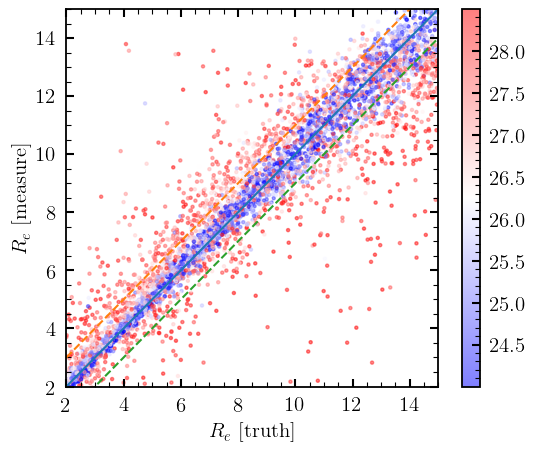

In [384]:
plt.scatter(re_truth, re_meas + p_bias(re_meas, SB_meas), 
            c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

<Chebyshev2D(1, 1, c0_0=-13.5482203, c1_0=0.51814401, c0_1=0.54644941, c1_1=-0.0188932)>

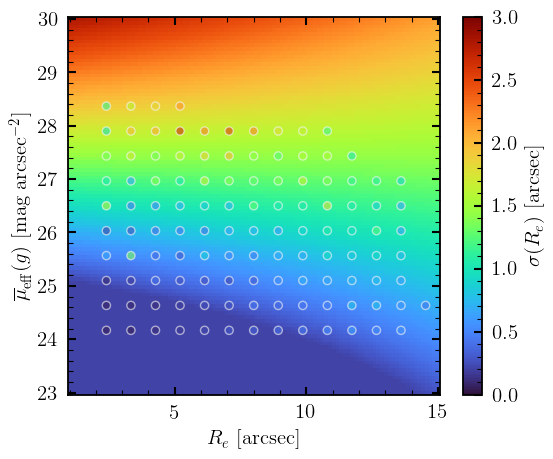

In [321]:
quant_error(np.vstack([re_meas, SB_meas]).T, re_meas - re_truth, 
            statistic='std',
            vmin=0, vmax=3, degree=[1, 1])

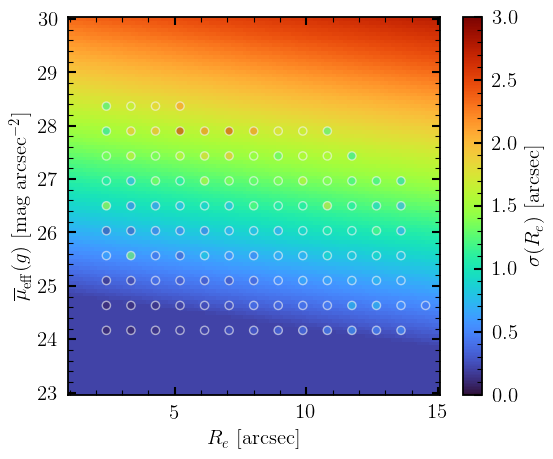

In [165]:
poly_error = quant_error(np.vstack([re_meas, SB_meas]).T, re_meas - re_truth, 
                         statistic='std', min_err=0.2,
                         degree=[1, 1], method='poly')

In [222]:
y = re_truth - re_meas #re_truth - re_truth_pred # 
X = np.vstack([re_meas, SB_meas]).T


n_bins = [15, 15]
min_num = 10
_range = [[1, 15], [23, 30]]
_extent = [item for sublist in _range for item in sublist]

ret = binned_statistic_dd(X, y, statistic='median', bins=n_bins, 
                          range=_range, expand_binnumbers=False)

ret_std = binned_statistic_dd(X, y, statistic='std', bins=n_bins, 
                              range=_range)

ret_cnt = binned_statistic_dd(X, y, statistic='count', bins=n_bins, 
                              range=_range, 
                              binned_statistic_result=ret_std)

flag = (ret_cnt.statistic < min_num)
ret.statistic[flag] = np.nan
ret_std.statistic[flag] = np.nan

# ret.statistic[:np.digitize(23.4, ret.bin_edges[1]), 
#               :np.digitize(5, ret.bin_edges[0])] = np.nan
# ret_std.statistic[:np.digitize(23.4, ret.bin_edges[1]), 
#                   :np.digitize(5, ret.bin_edges[0])] = np.nan

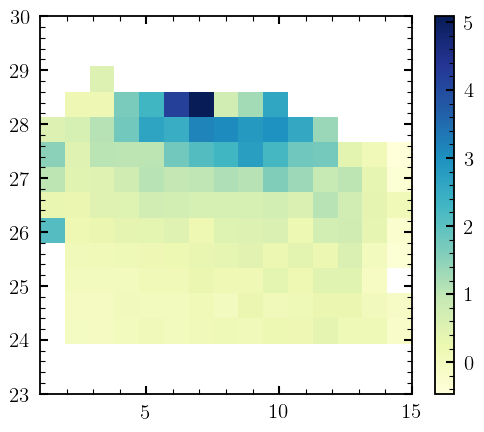

In [223]:
# plt.scatter(re_meas, SB_meas)
plt.imshow(ret.statistic.T, 
#            vmin=-1, vmax=1, 
           origin='lower',
           cmap='YlGnBu', 
           extent=_extent, 
           aspect='auto')
plt.colorbar()

In [224]:
def get_edge_cens(edges):
    return [0.5 * (_edge[:-1] + _edge[1:]) for _edge in edges]

In [287]:
x1, x2 = np.meshgrid(*get_edge_cens(ret.bin_edges))
X = np.vstack([x1.ravel(), x2.ravel()]).T

y = ret.statistic.T
Y = y.ravel()
flag = ~np.isnan(y)

x1 = x1[flag]
x2 = x2[flag]
y = y[flag]
#### y = np.nan_to_num(ret_std.statistic, nan=4)

Score: 0.7564279365709855


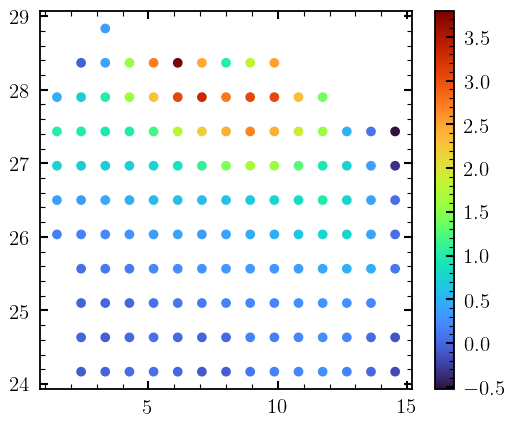

In [288]:
X = np.vstack([x1, x2]).T # , gi_meas, spergel_nu # spergel_nu
y = y
ppl = predict_bias(y, X)
re_truth_pred = ppl.predict(X)
# np.mean(re_truth_pred - y)

plt.scatter(x1, x2, c=re_truth_pred)
plt.colorbar()

(2.0, 15.0)

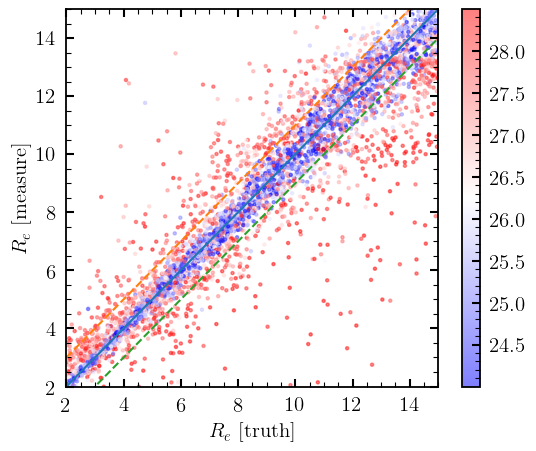

In [289]:
plt.scatter(re_truth, re_meas + ppl.predict(np.vstack([re_meas, SB_meas]).T), 
            c=SB_truth, 
            cmap='bwr',
#             vmin=23, vmax=29,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

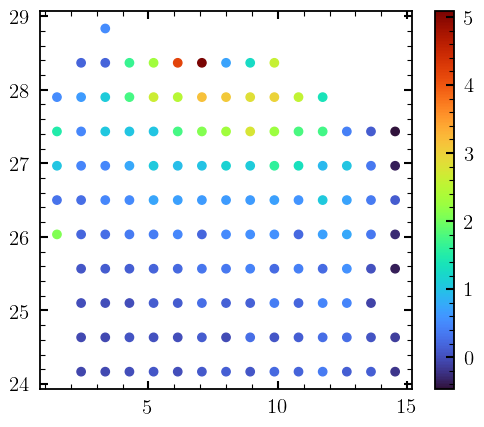

In [248]:
plt.scatter(x1, x2, c=y)
plt.colorbar()

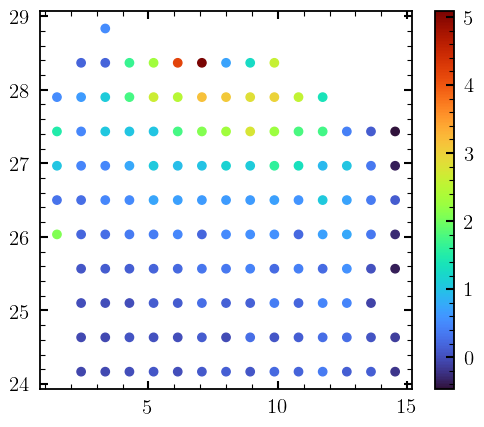

In [210]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.colorbar()

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

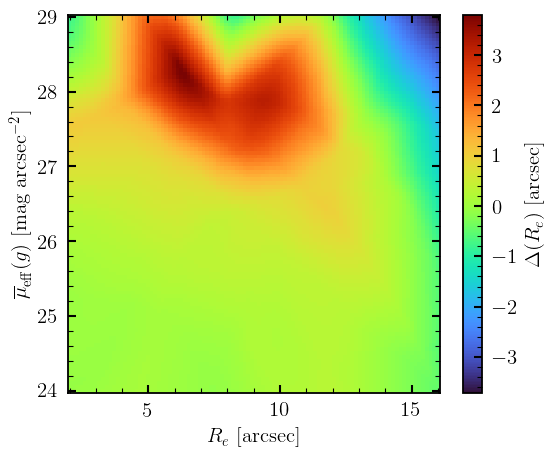

In [221]:
x1_test, x2_test = np.meshgrid(np.linspace(2, 16, 100), np.linspace(24, 29, 100))
C = ppl.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T).reshape(100, 100)
# C[C < 0] = 0
plt.pcolormesh(x1_test, x2_test, C)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')

# plt.scatter(X[:, 0], X[:, 1], c=Y, s=35, vmin=0, vmax=3, edgecolors='whitesmoke', alpha=0.6)

plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

In [228]:
from astropy.modeling import models, fitting
# p_init = models.Chebyshev2D(x_degree=1, y_degree=1)
p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, x1.ravel(), x2.ravel(), y.ravel())

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

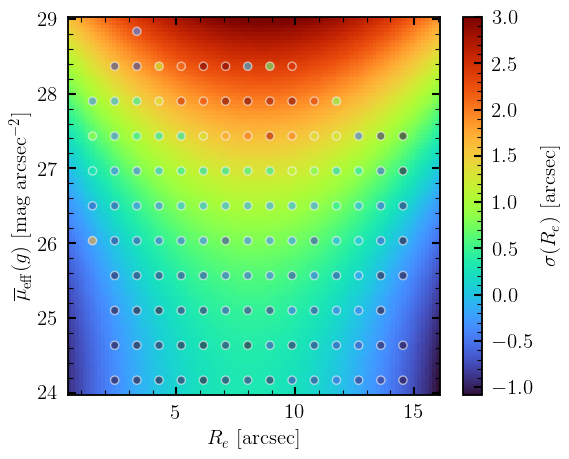

In [229]:
x1_test, x2_test = np.meshgrid(np.linspace(0.5, 16, 100), np.linspace(24, 29, 100))
C = p(x1_test, x2_test)
# C[C < 0.] = 0.
plt.pcolormesh(x1_test, x2_test, C, vmax=3)
plt.colorbar(label=r'$\sigma(R_e)$ [arcsec]')

plt.scatter(X[:, 0], X[:, 1], c=Y, s=35, vmin=0, vmax=3, edgecolors='whitesmoke', alpha=0.6)

plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

(2.0, 15.0)

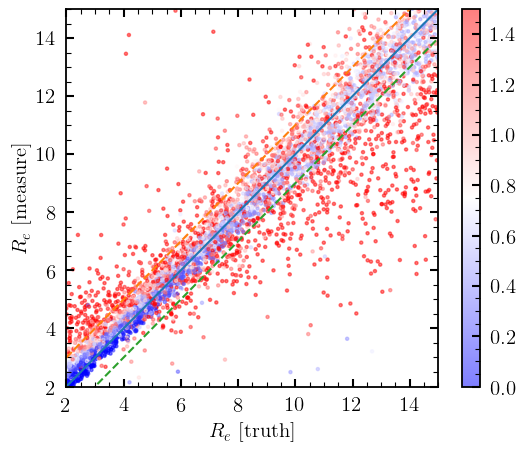

In [189]:
plt.scatter(re_truth, re_meas + p(re_meas, SB_meas), 
            c=sigma_re, 
            cmap='bwr',
            vmin=0, vmax=1.5,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [173]:
p(2, 29)

2.5462489365742726

In [50]:
sigma_re = p(re_meas, SB_meas)

(2.0, 15.0)

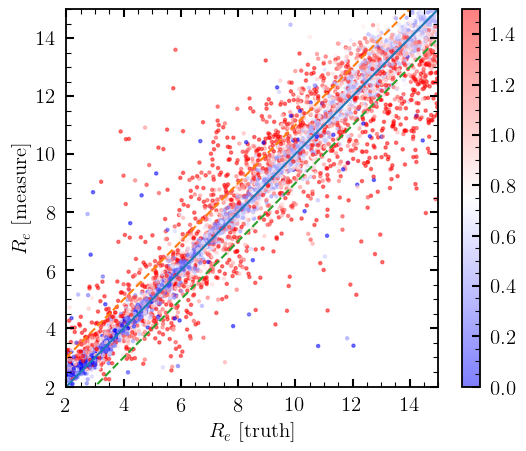

In [51]:
plt.scatter(re_truth, re_truth_pred, 
            c=sigma_re, 
            cmap='bwr',
            vmin=0, vmax=1.5,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

-0.8900440940253831 1.7686173782287535


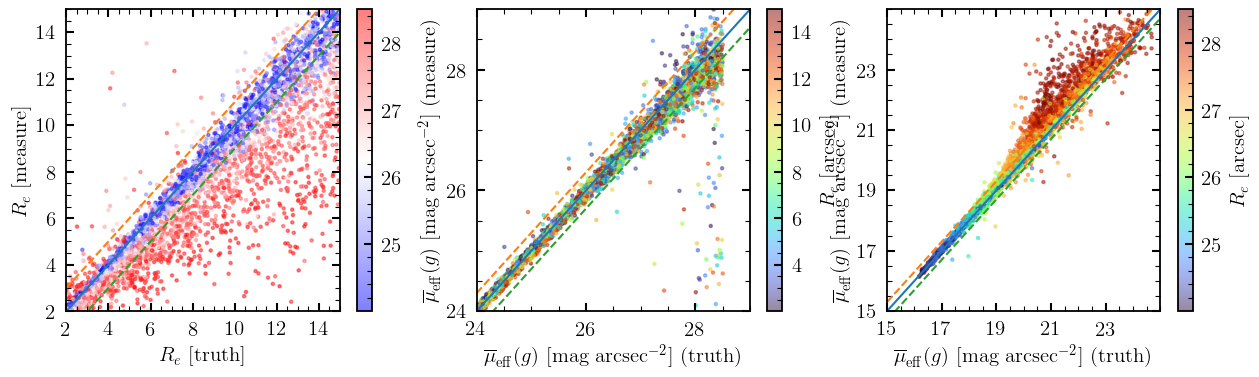

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)

In [242]:
X = np.vstack([re_meas, SB_meas, ]).T# , gi_meas, spergel_nu # spergel_nu
y = re_truth 
ppl = predict_bias(y, X)
re_truth_pred = ppl.predict(X)
# np.mean(re_truth_pred - y)

Score: 0.8932914617169537


Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

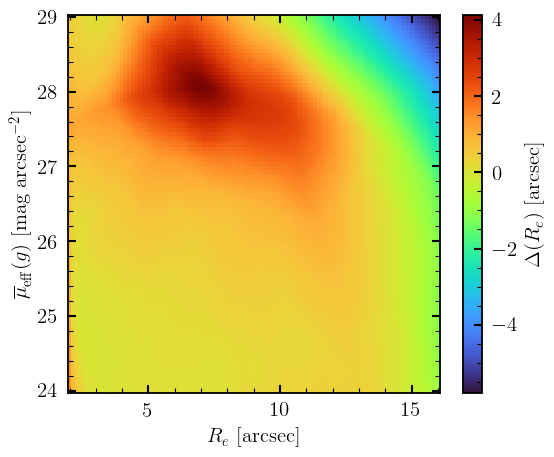

In [243]:
x1_test, x2_test = np.meshgrid(np.linspace(2, 16, 100), np.linspace(24, 29, 100))
C = ppl.predict(
    np.vstack([x1_test.ravel(), x2_test.ravel()]).T
).reshape(100, 100) - x1_test
# C[C < 0] = 0
plt.pcolormesh(x1_test, x2_test, C)
plt.colorbar(label=r'$\Delta(R_e)$ [arcsec]')

# plt.scatter(X[:, 0], X[:, 1], c=Y, s=35, vmin=0, vmax=3, edgecolors='whitesmoke', alpha=0.6)

plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')